In [39]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast 

import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import pandas as pd
from pathlib import Path
import tensorflow_io as tfio
import ast
from pathlib import Path

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D


**Build Data Loading Function**

In [40]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

**Create Tensorflow Dataset**

In [41]:
SOUND = os.path.join('..', 'Generator', 'audiodata')
SOUND

'..\\Generator_two\\audiodata'

In [42]:
import glob
import re

txtfiles = []
for file in glob.glob(SOUND+"\*.wav"):
    txtfiles.append(file)
txtfiles
sound = sorted(txtfiles, key=lambda s: int(re.search(r'\d+', s).group()))

In [43]:
values = pd.read_csv('../Generator/audiodata/data.csv')['osc'].tolist()
osc = list()
for value in values:
    if value == 'sine':
        osc.append(tf.one_hot(0,4))
    if value == 'square':
        osc.append(tf.one_hot(1,4))
    if value == 'sawtooth':
        osc.append(tf.one_hot(2,4))
    if value == 'triangle':
        osc.append(tf.one_hot(3,4))


data = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(sound), tf.data.Dataset.from_tensor_slices(osc)))

**Build Preprocessing Function to Convert to Spectrogram**

In [44]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:63901] 
    zero_padding = tf.zeros([63901] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    
    return spectrogram, label

**Create Training and Testing Partitions**

In [45]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [46]:
train = data.take(875)
test = data.skip(875).take(375)

**Build Model**

In [47]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(497, 257,1)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [48]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [49]:
model.summary() 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 495, 255, 32)      320       
                                                                 
 conv2d_19 (Conv2D)          (None, 493, 253, 32)      9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 246, 126, 32)     0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 244, 124, 64)      18496     
                                                                 
 conv2d_21 (Conv2D)          (None, 242, 122, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 121, 61, 64)      0         
 g2D)                                                 

**Train**

In [50]:
hist = model.fit(train, epochs=3, validation_data=test)

Epoch 1/3
875/875 [==============================] - 3535s 4s/step - loss: 0.2646 - recall_3: 0.8592 - precision_3: 0.9190 - val_loss: 0.0610 - val_recall_3: 0.9717 - val_precision_3: 0.9722
Epoch 2/3
875/875 [==============================] - 4279s 5s/step - loss: 0.1087 - recall_3: 0.9631 - precision_3: 0.9651 - val_loss: 0.0245 - val_recall_3: 0.9908 - val_precision_3: 0.9915
Epoch 3/3
875/875 [==============================] - 4096s 5s/step - loss: 0.0356 - recall_3: 0.9856 - precision_3: 0.9863 - val_loss: 0.0039 - val_recall_3: 0.9993 - val_precision_3: 0.9997


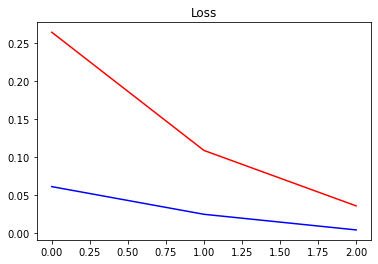

In [51]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

**Test Model with a Single Clip**

In [52]:
X_test, y_test = test.as_numpy_iterator().next()
y_test

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [53]:
yhat = model.predict(X_test)
#yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]
yhat

array([[8.4457389e-12, 4.3918428e-04, 8.3311826e-16, 9.9956077e-01],
       [1.0000000e+00, 4.5263789e-22, 1.7414943e-25, 1.3949982e-08],
       [2.4940384e-28, 1.2164527e-13, 1.0000000e+00, 0.0000000e+00],
       [6.1539336e-14, 2.3063762e-16, 0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 3.9169030e-26, 3.5122203e-30, 4.8328248e-09],
       [1.3946753e-09, 9.9725890e-01, 2.7285961e-03, 1.2493972e-05],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [1.9236450e-35, 5.2196001e-21, 0.0000000e+00, 1.0000000e+00],
       [5.5751389e-26, 1.0000000e+00, 2.1133523e-08, 2.1643551e-13],
       [2.2197894e-31, 1.0000000e+00, 1.0845084e-12, 3.5284309e-14],
       [5.4382567e-30, 1.1206579e-27, 0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 1.7828097e-36, 0.0000000e+00, 2.2903825e-10],
       [1.7845156e-11, 3.9808652e-03, 2.3880206e-13, 9.9601918e-01],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 5.6049013e-13],
       [9.9999976e-01, 1.0448085e-

In [54]:
score = model.evaluate(test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

375/375 [==============================] - 497s 1s/step - loss: 0.0040 - recall_3: 0.9992 - precision_3: 0.9997
Test loss: 0.0039763483218848705
Test accuracy: 0.9991666674613953


In [55]:
model_json = model.to_json()
with open("osc.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("osc.h5")